# HW10: Algorithmic Fairness 

### Note: to complete most of this homework notions from week 11 slides are needed

In this homework you will assess racial bias in the COMPAS algorithm and judges decisions. 

The data is a collection of 7000 criminal cases in Florida in which COMPAS was used and it contains information about defendants' demographics, criminal history (e.g., juvenile criminal records), court decision and recidivism.

In [158]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Data Preparation

In [159]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [161]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = (df['days_from_recid']<=730).astype(int)

#generate felony charge dummies
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

#generate age dummies
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45', 'Greater than 45':'age_cat_Greater than 45', 'Less than 25':'age_cat_Less than 25'})

#generate ethnicity, race and compas score dummies
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
df['male'] = (df['sex'] == 'Male').astype(int)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})

### Setting outcomes and predictors

The *ideal* target variable for the COMPAS algorithm is the presence of a recidivism episode, while for judges is the decision to send the defendant to jail. For the predictors we use some deomgraphic characteristics **excluding race**, criminal hisotry and type of crime. 

In [162]:
# judge decision: "jailed" = more than one day in jail.
df['jail_days'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['jailed'] = (df.jail_days.dt.days > 1).astype(int)
D = df['jailed']
D.value_counts()

0    4283
1    2931
Name: jailed, dtype: int64

In [163]:
# Algorithm outcome
Y = df['two_year_recid2'] 
Y.value_counts()

0    4557
1    2657
Name: two_year_recid2, dtype: int64

In [164]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


In [165]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [166]:
# indicator variable for non-white
NW = (df['race'] != 'Caucasian').astype(int)
NW.describe()

count    7214.000000
mean        0.659828
std         0.473800
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: race, dtype: float64

## Assessing Algorithm: Predict Recidivism from Features

In the following you will predict recidivism from defendants' features using a nested training/test split so we can get clean test-set predictions for the whole dataset (see the notebook and homework on double machine learning for how to do this - week 6).

In [167]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, D_train, D_test,NW_train, NW_test = train_test_split(X, Y, D, NW, test_size = 0.5)

df_pred = X_train.append(X_test) 
#TODO train a logit model to predict recidism (Y) from predictors (X).
#TODO form clean test-set predictions for recidivism in the full dataset
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

Evaluate test set performance.

accuracy_score:  0.6581646797892986
balanced_accuracy_score:  0.5639855672847859
roc_auc_score:  0.5639855672847859
[[2094  192]
 [1041  280]]
FP / FN =  0.1844380403458213


0.1844380403458213

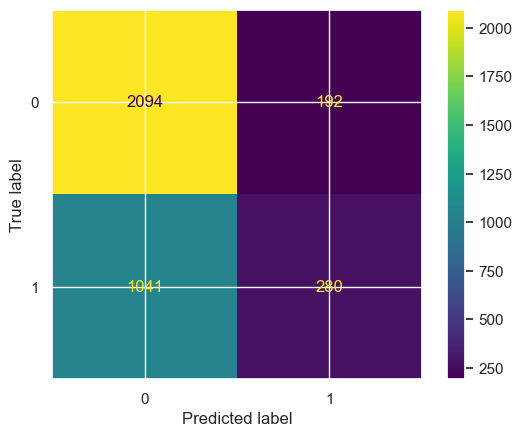

In [168]:
#TODO show a confusion matrix, compute accuracy, balanced accuracy, and roc_auc
#TODO compute ratio of false positives to false negatives

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import (precision_score, confusion_matrix, recall_score, f1_score, precision_recall_curve,
                             plot_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, auc, roc_auc_score)


plot_confusion_matrix(model, X_test, Y_test)

def report_stas(Y_test, Y_test_pred):
    print("accuracy_score: ", accuracy_score(Y_test, Y_test_pred))
    print("balanced_accuracy_score: ", balanced_accuracy_score(Y_test, Y_test_pred))
    print("roc_auc_score: ", roc_auc_score(Y_test, Y_test_pred))

    cm = confusion_matrix(Y_test, Y_test_pred)
    print(cm)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print("FP / FN = ", FP / FN)

    return FP / FN

report_stas(Y_test, Y_test_pred)


### Compare treatment of whites and non-whites for recidivism prediction
##### Refer to week 11 for these concepts

#### Base Rates

In [169]:
##TODO Compare base rates for recidivism outcomes of whites and non-whites

#df['male'] = (df['sex'] == 'Male').astype(int)
#NW = (df['race'] != 'Caucasian').astype(int)
#NW.rename(columns={'Not white'})
df_race_recid = pd.DataFrame(NW_test)
#df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})
df_race_recid['recid'] = Y_test
df_race_recid['recid_pred'] = Y_test_pred
df_race_recid.head()


white_recid = len(df_race_recid[(df_race_recid['race']==0) & (df_race_recid['recid']==1)])
white_base_rate = white_recid / len(df_race_recid[(df_race_recid['race']==0)]) 

non_white_recid = len(df_race_recid[(df_race_recid['race']==1) & (df_race_recid['recid']==1)])
non_white_base_rate =  non_white_recid / len(df_race_recid[(df_race_recid['race']==1)])

print('white_base_rate: ', white_base_rate)
print('non_white_base_rate: ', non_white_base_rate)

white_base_rate:  0.3211083944580277
non_white_base_rate:  0.38949579831932774


#### Performance

In [170]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, separately for whites and non-whites.
print('WHITE')
Y_test_white = df_race_recid[df_race_recid['race']==0]['recid']
Y_test_pred_white = df_race_recid[df_race_recid['race']==0]['recid_pred']
report_stas(Y_test_white, Y_test_pred_white)


print('\nNON WHITE')
Y_test_white = df_race_recid[df_race_recid['race']==1]['recid']
Y_test_pred_white = df_race_recid[df_race_recid['race']==1]['recid_pred']
report_stas(Y_test_white, Y_test_pred_white)

WHITE
accuracy_score:  0.6837815810920945
balanced_accuracy_score:  0.5377100078610124
roc_auc_score:  0.5377100078610124
[[788  45]
 [343  51]]
FP / FN =  0.13119533527696792

NON WHITE
accuracy_score:  0.6449579831932774
balanced_accuracy_score:  0.5729317240452554
roc_auc_score:  0.5729317240452555
[[1306  147]
 [ 698  229]]
FP / FN =  0.21060171919770773


0.21060171919770773

**What concepts of "fairness" (from class) are (approximately) satisfied by this classifier? Explain.**

> Groups fairness is guaranteed if we take "balanced_accuracy_score" or "roc_auc_score" as a metric. 
However we can if we consider "accuracy_score" or "FP / FN" we see group discrimination.

## Assessing Judges' Decisions: Predict Judge Decision from Features

In the following you will predict judges' decisions from defendants' features using a nested training/test split as before. In a second model, include Y-hat from previous section as a predictor.

In [171]:
#TODO train a logit model to predict judge decision (D) from predictors (X). 
# perform nested train/test split 
#X_train, X_test, Y_train, Y_test, D_train, D_test,NW_train, NW_test = train_test_split(X, Y, D, NW, test_size = 0.5)

#TODO train a logit model to predict recidism (Y) from predictors (X).
#TODO form clean test-set predictions for recidivism in the full dataset
#from sklearn.linear_model import LogisticRegression
model_D = LogisticRegression()
model_D.fit(X_train, D_train)
D_test_pred = model_D.predict(X_test)
D_train_pred = model_D.predict(X_train)

In [172]:
#TODO train a logit model to predict judge decision (D) from predictors (X) and predicted recidivism risk (Yhat)
#TODO form clean test-set predictions for the decisions in the full dataset
X_train['y_pred'] = Y_train_pred
X_test['y_pred'] = Y_test_pred
Xy = X_train.append(X_test)

model_D_with_y = LogisticRegression()
model_D_with_y.fit(X_train, D_train)
D_test_pred_with_y_pred = model_D_with_y.predict(X_test)
D_train_pred_with_y_pred = model_D_with_y.predict(X_train)
D_pred_with_y_pred = model_D_with_y.predict(Xy)


### Compare treatment of whites and non-whites for recidivism prediction

In [173]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, 
##TODO separately for whites and non-whites, and with/without including Y-hat as a predictor.

df_race_decision = pd.DataFrame(NW_test)
df_race_decision['decision'] = D_test
df_race_decision['decision_pred'] = D_test_pred
df_race_decision['decision_pred_with_y_pred'] = D_test_pred_with_y_pred
df_race_decision.head()


D_test_white = df_race_decision[df_race_decision['race']==0]['decision']
D_test_pred_white = df_race_decision[df_race_decision['race']==0]['decision_pred']
D_test_pred_wy_white = df_race_decision[df_race_decision['race']==0]['decision_pred_with_y_pred']
print('WHITE wihtout Y_pred')
report_stas(D_test_white, D_test_pred_white)
print('\nWHITE whit Y_pred')
report_stas(D_test_white, D_test_pred_wy_white)


D_test_non_white = df_race_decision[df_race_decision['race']==1]['decision']
D_test_pred_non_white = df_race_decision[df_race_decision['race']==1]['decision_pred']
D_test_pred_wy_non_white = df_race_decision[df_race_decision['race']==1]['decision_pred_with_y_pred']
print('\nNON WHITE wihtout Y_pred')
report_stas(D_test_non_white, D_test_pred_non_white)
print('\nNON WHITE whit Y_pred')
report_stas(D_test_non_white, D_test_pred_wy_non_white)

WHITE wihtout Y_pred
accuracy_score:  0.6487367563162184
balanced_accuracy_score:  0.564899775528689
roc_auc_score:  0.564899775528689
[[698  60]
 [371  98]]
FP / FN =  0.16172506738544473

WHITE whit Y_pred
accuracy_score:  0.6479217603911981
balanced_accuracy_score:  0.5674918847151352
roc_auc_score:  0.5674918847151352
[[689  69]
 [363 106]]
FP / FN =  0.19008264462809918

NON WHITE wihtout Y_pred
accuracy_score:  0.6197478991596639
balanced_accuracy_score:  0.5710084921730265
roc_auc_score:  0.5710084921730264
[[1176  235]
 [ 670  299]]
FP / FN =  0.35074626865671643

NON WHITE whit Y_pred
accuracy_score:  0.623109243697479
balanced_accuracy_score:  0.5761062827160033
roc_auc_score:  0.5761062827160033
[[1170  241]
 [ 656  313]]
FP / FN =  0.3673780487804878


0.3673780487804878

In this part you will find the the group-specific thresholds for both models of judges' decision (with/without Yhat) that obtain statistical parity.

You can use a custom classifier `threshold` for the decision with this type of code snippet: `decisions = (logit.predict_proba(X) >= threshold).astype(int)`.

### Enforcing Statistical Parity

#### Model without Yhat

In [174]:
D_pred = (model_D.predict_proba(X) >= 0.6).astype(int)
D_pred

array([[1, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [1, 0],
       [1, 0]])

In [175]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites
import numpy as np

best_loss = 1000000000000000
best_threshold = None

for threshold in np.linspace(0, 1, num=50):
    D_pred = (model_D.predict_proba(X) >= threshold).astype(int)[:,1]

    df_race_decision_calib = pd.DataFrame(NW)
    df_race_decision_calib['decision'] = D
    df_race_decision_calib['decision_pred'] = D_pred

    D_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision']
    D_pred_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision_pred']
    D_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision']
    D_pred_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision_pred']
    
    loss = abs(accuracy_score(D_white, D_pred_white) - accuracy_score(D_non_white, D_pred_non_white))
    if loss < best_loss:
        best_loss = loss
        best_threshold = threshold

print("The best threshold is ",best_threshold, "which achieves ", best_loss, "% difference in accuracy.")
    

The best threshold is  0.24489795918367346 which achieves  0.005499339099943157 % difference in accuracy.


#### Model with Yhat

In [176]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

best_loss = 1000000000000000
best_threshold = None

for threshold in np.linspace(0, 1, num=100):
    D_pred = (model_D.predict_proba(X) >= threshold).astype(int)[:,1]

    df_race_decision_calib = pd.DataFrame(NW)
    df_race_decision_calib['decision'] = D
    df_race_decision_calib['decision_pred_wy'] = D_pred_with_y_pred

    D_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision']
    D_pred_wy_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision_pred_wy']
    D_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision']
    D_pred_wy_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision_pred_wy']
    
    loss = abs(accuracy_score(D_white, D_pred_wy_white) - accuracy_score(D_non_white, D_pred_wy_non_white))
    if loss < best_loss:
        best_loss = loss
        best_threshold = threshold

print("The best threshold is ",best_threshold, "which achieves ", best_loss, "% difference in accuracy.")

The best threshold is  0.0 which achieves  0.014321327553026064 % difference in accuracy.


# Bonus 1: More Fairness Constraints

Find the threshold for both models (with/without Yhat) that obtains error rate balance (equality of recalls for each class.

In [177]:
##TODO

def calibrate_recall(uncalibrated_model, dataX):
    best_loss = 1000000000000000
    best_threshold = None

    for threshold in np.linspace(0, 1, num=50):
        D_pred = (uncalibrated_model.predict_proba(dataX) >= threshold).astype(int)[:,1]

        df_race_decision_calib = pd.DataFrame(NW)
        df_race_decision_calib['decision'] = D
        df_race_decision_calib['decision_pred'] = D_pred

        D_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision']
        D_pred_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision_pred']
        D_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision']
        D_pred_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision_pred']
        
        loss = abs(recall_score(D_white, D_pred_white) - recall_score(D_non_white, D_pred_non_white))
        if loss < best_loss:
            best_loss = loss
            best_threshold = threshold

    print("The best threshold is ",best_threshold, "which achieves ", best_loss, "% difference in recall.")


calibrate_recall(model_D, X)
calibrate_recall(model_D_with_y, Xy)

The best threshold is  0.0 which achieves  0.0 % difference in recall.
The best threshold is  0.0 which achieves  0.0 % difference in recall.


Find the threshold for both models (with/without Yhat) that obtains predictive parity (equality of precisions for each class).

In [178]:
##TODO
def calibrate_precision(uncalibrated_model, dataX):
    best_loss = 1000000000000000
    best_threshold = None

    for threshold in np.linspace(0, 1, num=50):
        D_pred = (uncalibrated_model.predict_proba(dataX) >= threshold).astype(int)[:,1]

        df_race_decision_calib = pd.DataFrame(NW)
        df_race_decision_calib['decision'] = D
        df_race_decision_calib['decision_pred'] = D_pred

        D_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision']
        D_pred_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision_pred']
        D_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision']
        D_pred_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision_pred']
        
        loss = abs(precision_score(D_white, D_pred_white) - precision_score(D_non_white, D_pred_non_white))
        if loss < best_loss:
            best_loss = loss
            best_threshold = threshold

    print("The best threshold is ",best_threshold, "which achieves ", best_loss, "% difference in precision.")


calibrate_precision(model_D, X)
calibrate_precision(model_D_with_y, Xy)

The best threshold is  0.9591836734693877 which achieves  0.0 % difference in precision.


/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom

The best threshold is  0.9591836734693877 which achieves  0.0 % difference in precision.


/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom

Find the threshold for both models (with/without Yhat) that obtains treatment equality (ratio of false positives to false negatives).

In [179]:
##TODO


def FPFN(Y, Y_pred):
    cm = confusion_matrix(Y, Y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    return FP / FN

def calibrate_FPFN(uncalibrated_model, dataX):
    best_loss = 1000000000000000
    best_threshold = None

    for threshold in np.linspace(0, 1, num=50):
        D_pred = (uncalibrated_model.predict_proba(dataX) >= threshold).astype(int)[:,1]

        df_race_decision_calib = pd.DataFrame(NW)
        df_race_decision_calib['decision'] = D
        df_race_decision_calib['decision_pred'] = D_pred

        D_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision']
        D_pred_white = df_race_decision_calib[df_race_decision_calib['race']==0]['decision_pred']
        D_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision']
        D_pred_non_white = df_race_decision_calib[df_race_decision_calib['race']==1]['decision_pred']
        
        loss = abs(FPFN(D_white, D_pred_white) - FPFN(D_non_white, D_pred_non_white))
        if loss < best_loss:
            best_loss = loss
            best_threshold = threshold

    print("The best threshold is ",best_threshold, "which achieves ", best_loss, "% difference in ratio of false positives to false negatives.")


calibrate_FPFN(model_D, X)
calibrate_FPFN(model_D_with_y, Xy)

/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  return FP / FN
/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  return FP / FN
/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:28: RuntimeWarning: invalid value encountered in double_scalars
  loss = abs(FPFN(D_white, D_pred_white) - FPFN(D_non_white, D_pred_non_white))
/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  return FP / FN
/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  return FP / FN
/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_63570/1064066095.py:28: RuntimeWarning: invalid value encountered in double_scalar

The best threshold is  0.9795918367346939 which achieves  0.0 % difference in ratio of false positives to false negatives.
The best threshold is  0.9795918367346939 which achieves  0.0 % difference in ratio of false positives to false negatives.


Note 1: the threshold at 0 for calibrating the recall is trivially right but clearly unfair.

Note 2: These experiments shows how it's hvery hard to impossible to calibrate for several different fairness metric   

# Bonus 2: Pre-Processing for Fairness

Regress all predictors in `X` on the protected attribute `A` and produce residuals `Xtilde`. Re-do the prediction task above (predicting judges' decision) and discuss how it changes the fairness metrics.

In [180]:
##TODO